In [1]:
import matplotlib.pyplot as plt
import seaborn as sbs

import random
import math
import numpy as np
from numpy import array

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

IBMQ.load_account()

from qinfer import FiniteOutcomeModel, DifferentiableModel
from qinfer.smc import SMCUpdater

sbs.set(style="darkgrid")

import matplotlib.lines as mlines

import qiskit.ignis.verification.randomized_benchmarking as rb
%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [155]:
def design_circuit(n_qubits, inv_arr):
    circuit = QuantumCircuit(n_qubits, n_qubits)
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.barrier(i)
            circuit.x(i)
            circuit.barrier(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [156]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_vigo')

results = []

n_qubits = 5

range_max = 2 ** n_qubits
for i in range(range_max):
    # Slapshod generator for the inversion array
    curr_inversion_arr = list(map(int, list(bin(i)[2:])))
    curr_inversion_arr = [0] * (n_qubits - len(curr_inversion_arr)) + curr_inversion_arr
    curr_inversion_arr = np.array(curr_inversion_arr)
    print(curr_inversion_arr)
    
    circuit = design_circuit(n_qubits, curr_inversion_arr)
    
    try:
        circuit_op_0 = transpile(circuit, backend=backend, optimization_level=0)
        job = execute(circuit_op_0, backend, shots=1000)
    except:
        continue
        
    result = job.result()
    
    results.append([curr_inversion_arr, result.get_counts(circuit_op_0)])

[0 0 0 0 0]
[0 0 0 0 1]
[0 0 0 1 0]
[0 0 0 1 1]
[0 0 1 0 0]
[0 0 1 0 1]
[0 0 1 1 0]
[0 0 1 1 1]
[0 1 0 0 0]
[0 1 0 0 1]
[0 1 0 1 0]
[0 1 0 1 1]
[0 1 1 0 0]
[0 1 1 0 1]
[0 1 1 1 0]
[0 1 1 1 1]
[1 0 0 0 0]
[1 0 0 0 1]
[1 0 0 1 0]
[1 0 0 1 1]
[1 0 1 0 0]
[1 0 1 0 1]
[1 0 1 1 0]
[1 0 1 1 1]
[1 1 0 0 0]
[1 1 0 0 1]
[1 1 0 1 0]
[1 1 0 1 1]
[1 1 1 0 0]
[1 1 1 0 1]
[1 1 1 1 0]
[1 1 1 1 1]


In [159]:
print(results)

[[array([0, 0, 0, 0, 0]), {'00000': 974, '00010': 4, '00001': 4, '11000': 3, '00100': 1, '00011': 1, '01000': 4, '10000': 9}], [array([0, 0, 0, 0, 1]), {'00000': 26, '00010': 1, '10100': 4, '11000': 10, '10001': 1, '01000': 4, '10010': 8, '10000': 946}], [array([0, 0, 0, 1, 0]), {'00000': 54, '01001': 5, '11000': 12, '10000': 1, '01011': 1, '01000': 919, '01010': 6, '01100': 2}], [array([0, 0, 0, 1, 1]), {'00000': 3, '11100': 1, '11001': 4, '11011': 1, '11000': 925, '10001': 1, '01000': 23, '01010': 1, '10000': 36, '11010': 5}], [array([0, 0, 1, 0, 0]), {'00000': 21, '10100': 2, '10101': 1, '00110': 8, '00100': 954, '00101': 7, '00111': 1, '01100': 6}], [array([0, 0, 1, 0, 1]), {'00000': 1, '11100': 6, '10100': 940, '10110': 6, '10111': 1, '10101': 4, '10000': 24, '00100': 16, '10010': 1, '00110': 1}], [array([0, 0, 1, 1, 0]), {'01111': 1, '11100': 4, '11000': 1, '00100': 36, '01110': 9, '01000': 21, '01100': 919, '01101': 9}], [array([0, 0, 1, 1, 1]), {'11100': 884, '11101': 4, '10100

In [17]:
print(results)

[[array([0, 0, 0, 0, 0]), {'00001': 4, '00010': 10, '11000': 1, '10000': 3, '00000': 845, '01100': 3, '00100': 115, '00110': 2, '01000': 17}], [array([0, 0, 0, 0, 1]), {'10101': 1, '00001': 1, '11000': 4, '10000': 800, '10010': 8, '00000': 72, '10100': 94, '10001': 5, '00100': 15}], [array([0, 0, 0, 1, 0]), {'01101': 1, '01110': 3, '00010': 1, '11000': 5, '10000': 1, '01010': 9, '00000': 51, '01100': 126, '00100': 17, '01001': 6, '01000': 780}], [array([0, 0, 0, 1, 1]), {'10101': 1, '01110': 2, '11010': 13, '11000': 715, '10000': 39, '11101': 1, '10100': 12, '00000': 6, '11110': 3, '01010': 4, '01100': 15, '11001': 2, '11100': 110, '01000': 77}], [array([0, 0, 1, 0, 0]), {'10100': 4, '00000': 100, '01100': 5, '00100': 871, '00101': 4, '00110': 13, '00111': 1, '01000': 2}], [array([0, 0, 1, 0, 1]), {'10101': 6, '11000': 5, '10000': 85, '10100': 805, '00000': 8, '01100': 2, '10001': 1, '00100': 77, '00101': 1, '11100': 4, '00110': 1, '10110': 5}], [array([0, 0, 1, 1, 0]), {'01101': 2, '0

In [160]:
results_london = [[array([0, 0, 0, 0, 0]), {'00001': 4, '00010': 10, '11000': 1, '10000': 3, '00000': 845, '01100': 3, '00100': 115, '00110': 2, '01000': 17}], [array([0, 0, 0, 0, 1]), {'10101': 1, '00001': 1, '11000': 4, '10000': 800, '10010': 8, '00000': 72, '10100': 94, '10001': 5, '00100': 15}], [array([0, 0, 0, 1, 0]), {'01101': 1, '01110': 3, '00010': 1, '11000': 5, '10000': 1, '01010': 9, '00000': 51, '01100': 126, '00100': 17, '01001': 6, '01000': 780}], [array([0, 0, 0, 1, 1]), {'10101': 1, '01110': 2, '11010': 13, '11000': 715, '10000': 39, '11101': 1, '10100': 12, '00000': 6, '11110': 3, '01010': 4, '01100': 15, '11001': 2, '11100': 110, '01000': 77}], [array([0, 0, 1, 0, 0]), {'10100': 4, '00000': 100, '01100': 5, '00100': 871, '00101': 4, '00110': 13, '00111': 1, '01000': 2}], [array([0, 0, 1, 0, 1]), {'10101': 6, '11000': 5, '10000': 85, '10100': 805, '00000': 8, '01100': 2, '10001': 1, '00100': 77, '00101': 1, '11100': 4, '00110': 1, '10110': 5}], [array([0, 0, 1, 1, 0]), {'01101': 2, '01110': 15, '01010': 1, '10100': 1, '00000': 2, '01100': 840, '00100': 52, '01001': 1, '11100': 6, '01000': 80}], [array([0, 0, 1, 1, 1]), {'01110': 4, '11010': 3, '11000': 66, '10000': 7, '11110': 4, '10100': 45, '01100': 63, '00100': 3, '11100': 797, '10110': 2, '01000': 6}], [array([0, 1, 0, 0, 0]), {'01110': 1, '00010': 812, '10000': 1, '01010': 2, '10010': 2, '00000': 38, '00011': 6, '00100': 13, '00101': 1, '00110': 123, '00111': 1}], [array([0, 1, 0, 0, 1]), {'11010': 3, '10011': 3, '10000': 38, '00010': 74, '10010': 743, '00000': 3, '10100': 5, '01100': 1, '00100': 1, '00110': 11, '10110': 115, '01000': 3}], [array([0, 1, 0, 1, 0]), {'01111': 2, '01110': 119, '11010': 2, '11110': 1, '00010': 51, '01010': 763, '00000': 2, '01100': 2, '01001': 1, '11100': 1, '00110': 9, '01011': 5, '01000': 42}], [array([0, 1, 0, 1, 1]), {'01110': 7, '11010': 718, '11000': 49, '10000': 1, '11110': 117, '10010': 38, '00010': 3, '01010': 55, '11111': 1, '11011': 1, '11100': 3, '10110': 6, '01000': 1}], [array([0, 1, 1, 0, 0]), {'01110': 6, '00010': 78, '01010': 1, '10010': 1, '00000': 5, '10100': 1, '00011': 1, '00100': 46, '00110': 852, '10110': 5, '00111': 3, '01000': 1}], [array([0, 1, 1, 0, 1]), {'10101': 1, '01110': 2, '11010': 2, '11110': 2, '10000': 3, '00010': 4, '10010': 83, '10100': 50, '10111': 4, '01100': 2, '00100': 1, '00110': 56, '10110': 790}], [array([0, 1, 1, 1, 0]), {'01111': 6, '01101': 3, '01110': 780, '11110': 5, '00010': 1, '01010': 89, '01100': 55, '00100': 3, '11100': 2, '00110': 52, '01000': 4}], [array([0, 1, 1, 1, 1]), {'01110': 60, '11010': 70, '11000': 2, '11101': 1, '11110': 757, '10010': 5, '01010': 4, '01100': 6, '11111': 4, '11011': 2, '11100': 39, '00110': 3, '10110': 47}], [array([1, 0, 0, 0, 0]), {'00001': 782, '01101': 1, '00010': 3, '00000': 59, '00011': 22, '10001': 3, '00100': 9, '00101': 115, '01001': 4, '00111': 1, '01000': 1}], [array([1, 0, 0, 0, 1]), {'10101': 128, '00001': 64, '10011': 22, '10000': 48, '11000': 1, '10010': 1, '00000': 5, '10100': 10, '10111': 1, '10001': 697, '00011': 2, '11001': 8, '00101': 9, '01001': 2, '10110': 2}], [array([1, 0, 0, 1, 0]), {'00001': 46, '01111': 4, '01101': 133, '11000': 1, '00000': 5, '00011': 3, '10001': 2, '01100': 8, '00100': 1, '11001': 3, '00101': 10, '01001': 715, '00111': 1, '01011': 11, '01000': 57}], [array([1, 0, 0, 1, 1]), {'01101': 14, '11010': 1, '11000': 41, '10000': 5, '11101': 99, '11111': 2, '11001': 683, '11011': 7, '00101': 1, '01001': 67, '01011': 3, '10101': 10, '00001': 6, '01111': 1, '01100': 1, '10001': 50, '11100': 8, '01000': 1}], [array([1, 0, 1, 0, 0]), {'10101': 3, '00001': 93, '01101': 2, '00000': 5, '00011': 1, '10001': 3, '01100': 2, '00100': 55, '00101': 829, '01001': 2, '00111': 5}], [array([1, 0, 1, 0, 1]), {'10101': 771, '00001': 8, '01101': 1, '10011': 2, '10000': 2, '11000': 1, '10100': 48, '11101': 4, '10111': 13, '10001': 80, '00100': 2, '11001': 1, '00101': 66, '10110': 1}], [array([1, 0, 1, 1, 0]), {'10101': 2, '00001': 3, '01111': 19, '01101': 777, '11101': 8, '01100': 55, '00100': 1, '00101': 39, '01001': 88, '00111': 2, '01011': 3, '01000': 3}], [array([1, 0, 1, 1, 1]), {'01101': 63, '11010': 1, '11000': 4, '10000': 1, '11101': 736, '11111': 5, '11001': 71, '11011': 2, '00101': 6, '01001': 9, '10101': 47, '01111': 3, '10100': 3, '01100': 4, '10001': 3, '11100': 41, '01000': 1}], [array([1, 1, 0, 0, 0]), {'00001': 102, '01111': 2, '00010': 39, '10011': 4, '01010': 1, '10111': 1, '10001': 1, '00011': 709, '00101': 17, '01001': 1, '00110': 10, '00111': 109, '01011': 4}], [array([1, 1, 0, 0, 1]), {'01101': 2, '11010': 1, '10011': 679, '10000': 1, '10111': 84, '00011': 67, '11111': 1, '11011': 5, '00101': 2, '01001': 1, '00110': 1, '10101': 16, '00001': 11, '01111': 1, '00010': 2, '10010': 28, '10001': 86, '10110': 6, '00111': 6}], [array([1, 1, 0, 1, 0]), {'00001': 2, '01111': 84, '01101': 5, '01110': 4, '11010': 1, '10011': 1, '00010': 5, '01010': 49, '00011': 32, '11001': 2, '00101': 2, '01001': 47, '00111': 5, '01011': 759, '01000': 2}], [array([1, 1, 0, 1, 1]), {'01110': 3, '11010': 42, '10011': 37, '11000': 1, '11101': 8, '01010': 6, '10111': 6, '00011': 3, '11111': 101, '11001': 51, '11011': 653, '01001': 4, '01011': 64, '01111': 5, '11110': 8, '10010': 1, '10100': 1, '10001': 3, '00111': 2, '01000': 1}], [array([1, 1, 1, 0, 0]), {'00001': 5, '01111': 2, '00010': 7, '10011': 1, '10111': 1, '00011': 84, '00100': 4, '00101': 53, '00110': 47, '00111': 796}], [array([1, 1, 1, 0, 1]), {'01101': 5, '10011': 66, '10000': 1, '11101': 1, '10111': 730, '00011': 7, '11111': 4, '00101': 1, '00110': 4, '10101': 42, '01111': 2, '10010': 4, '10100': 5, '10001': 5, '10110': 51, '00111': 72}], [array([1, 1, 1, 1, 0]), {'01101': 55, '01110': 69, '11101': 3, '01010': 2, '10111': 1, '00011': 6, '11111': 2, '11011': 1, '00101': 1, '01001': 3, '00110': 3, '01011': 78, '01111': 727, '00010': 1, '01100': 4, '00111': 44}], [array([1, 1, 1, 1, 1]), {'01101': 4, '01110': 6, '11010': 1, '10011': 5, '11101': 41, '01010': 1, '10111': 36, '00011': 3, '11111': 705, '11001': 4, '11011': 66, '01011': 6, '10101': 3, '01111': 65, '11110': 44, '11100': 4, '10110': 2, '00111': 4}]]
results_virgo = [[array([0, 0, 0, 0, 0]), {'00000': 974, '00010': 4, '00001': 4, '11000': 3, '00100': 1, '00011': 1, '01000': 4, '10000': 9}], [array([0, 0, 0, 0, 1]), {'00000': 26, '00010': 1, '10100': 4, '11000': 10, '10001': 1, '01000': 4, '10010': 8, '10000': 946}], [array([0, 0, 0, 1, 0]), {'00000': 54, '01001': 5, '11000': 12, '10000': 1, '01011': 1, '01000': 919, '01010': 6, '01100': 2}], [array([0, 0, 0, 1, 1]), {'00000': 3, '11100': 1, '11001': 4, '11011': 1, '11000': 925, '10001': 1, '01000': 23, '01010': 1, '10000': 36, '11010': 5}], [array([0, 0, 1, 0, 0]), {'00000': 21, '10100': 2, '10101': 1, '00110': 8, '00100': 954, '00101': 7, '00111': 1, '01100': 6}], [array([0, 0, 1, 0, 1]), {'00000': 1, '11100': 6, '10100': 940, '10110': 6, '10111': 1, '10101': 4, '10000': 24, '00100': 16, '10010': 1, '00110': 1}], [array([0, 0, 1, 1, 0]), {'01111': 1, '11100': 4, '11000': 1, '00100': 36, '01110': 9, '01000': 21, '01100': 919, '01101': 9}], [array([0, 0, 1, 1, 1]), {'11100': 884, '11101': 4, '10100': 28, '11000': 37, '11111': 1, '11110': 10, '00100': 3, '01000': 1, '01100': 29, '01101': 1, '11010': 2}], [array([0, 1, 0, 0, 0]), {'00000': 39, '10010': 5, '00010': 937, '00001': 3, '00101': 1, '00011': 7, '01000': 1, '01010': 3, '00110': 2, '11010': 2}], [array([0, 1, 0, 0, 1]), {'00000': 2, '00010': 31, '10110': 4, '10001': 2, '10011': 12, '10010': 911, '10000': 35, '11010': 3}], [array([0, 1, 0, 1, 0]), {'00000': 1, '01001': 1, '00010': 47, '10010': 2, '01110': 2, '00011': 1, '01000': 45, '01011': 5, '01010': 880, '00110': 5, '11010': 11}], [array([0, 1, 0, 1, 1]), {'10010': 50, '11011': 10, '10110': 5, '11000': 24, '11110': 2, '01000': 1, '01010': 30, '10000': 2, '11010': 876}], [array([0, 1, 1, 0, 0]), {'00000': 3, '00010': 26, '10110': 11, '10111': 1, '11110': 1, '00100': 45, '00101': 1, '01110': 8, '01010': 1, '00110': 895, '00111': 8}], [array([0, 1, 1, 0, 1]), {'00010': 1, '10100': 40, '10110': 871, '11111': 1, '10111': 7, '10101': 1, '10000': 1, '10011': 2, '11110': 9, '00100': 1, '10010': 38, '00110': 28}], [array([0, 1, 1, 1, 0]), {'01111': 10, '11100': 1, '00010': 3, '00110': 24, '11110': 5, '00100': 1, '01110': 896, '01000': 2, '01010': 27, '01100': 30, '00111': 1}], [array([0, 1, 1, 1, 1]), {'01111': 1, '11100': 40, '10010': 1, '10100': 2, '10110': 36, '11000': 1, '11111': 7, '10111': 1, '00110': 1, '11110': 844, '01110': 32, '01010': 1, '01100': 1, '11101': 4, '11010': 28}], [array([1, 0, 0, 0, 0]), {'00000': 16, '00101': 1, '01001': 6, '00001': 968, '11001': 1, '00011': 3, '10001': 5}], [array([1, 0, 0, 0, 1]), {'00000': 1, '01001': 1, '00001': 27, '11001': 7, '10001': 933, '10101': 2, '10011': 2, '00011': 2, '10010': 1, '10000': 24}], [array([1, 0, 0, 1, 0]), {'01001': 901, '00010': 14, '00001': 46, '11001': 7, '10001': 2, '00101': 2, '00011': 6, '01000': 11, '01011': 8, '01010': 3}], [array([1, 0, 0, 1, 1]), {'01001': 29, '00010': 2, '00001': 1, '11001': 875, '11011': 8, '11000': 23, '10001': 39, '10011': 2, '00011': 1, '01000': 1, '10010': 15, '11101': 4}], [array([1, 0, 1, 0, 0]), {'01001': 1, '11101': 1, '00010': 5, '00001': 26, '10101': 5, '00100': 17, '00101': 930, '00011': 1, '00111': 8, '01101': 6}], [array([1, 0, 1, 0, 1]), {'00001': 1, '10100': 24, '10110': 3, '10111': 3, '10001': 29, '10101': 900, '00101': 27, '10010': 4, '11101': 8, '00111': 1}], [array([1, 0, 1, 1, 0]), {'01001': 19, '01111': 15, '00001': 2, '11001': 1, '10101': 1, '00100': 2, '01000': 1, '01101': 864, '00111': 7, '00110': 20, '00101': 39, '01110': 2, '00011': 1, '01010': 3, '01100': 17, '11101': 6}], [array([1, 0, 1, 1, 1]), {'01001': 1, '11100': 20, '11001': 22, '10110': 17, '11000': 1, '11111': 17, '10101': 53, '10011': 1, '01101': 25, '11010': 3, '11011': 2, '10111': 4, '10001': 1, '11110': 4, '00101': 5, '00110': 1, '11101': 823}], [array([1, 1, 0, 0, 0]), {'00000': 1, '00010': 17, '00001': 59, '11011': 2, '10011': 2, '00011': 908, '01011': 10, '01101': 1}], [array([1, 1, 0, 0, 1]), {'00000': 1, '00010': 2, '00001': 3, '11001': 1, '11011': 4, '10001': 55, '10011': 863, '00011': 45, '01011': 1, '10010': 21, '10000': 3, '11010': 1}], [array([1, 1, 0, 1, 0]), {'01001': 50, '01111': 4, '00010': 2, '00001': 3, '11011': 3, '10011': 2, '00011': 47, '01000': 1, '01011': 868, '01010': 18, '00111': 2}], [array([1, 1, 0, 1, 1]), {'01001': 1, '11001': 49, '11011': 848, '11000': 1, '11111': 1, '10111': 1, '10001': 4, '10011': 43, '11110': 1, '00011': 1, '01011': 31, '10010': 1, '11010': 18}], [array([1, 1, 1, 0, 0]), {'01111': 24, '00001': 3, '11111': 1, '10111': 6, '10011': 1, '00100': 2, '00101': 29, '00011': 22, '01011': 2, '00111': 885, '00110': 24, '01101': 1}], [array([1, 1, 1, 0, 1]), {'01111': 3, '11011': 1, '10110': 24, '11111': 7, '10111': 872, '10101': 40, '10011': 26, '11110': 1, '00101': 2, '00111': 24}], [array([1, 1, 1, 1, 0]), {'01001': 2, '01111': 877, '11011': 2, '11111': 5, '10111': 2, '00100': 1, '00101': 3, '01110': 18, '00011': 1, '01011': 26, '01010': 1, '01101': 33, '00111': 29}], [array([1, 1, 1, 1, 1]), {'01111': 34, '11100': 1, '10100': 1, '11001': 2, '11011': 30, '10110': 1, '11111': 824, '10111': 60, '10101': 5, '10011': 1, '11110': 14, '00011': 1, '00111': 4, '11010': 2, '11101': 20}]]


In [114]:
print(results[5][0])
print(np.array(list((map(int, list(reversed(''.join(list(map(str, results[5][0]))))))))))

[0 0 1 0 1]
[1 0 1 0 0]


In [130]:
def bootstrap(results, target=0, samples=900, repeats=1000):
    sampler = []
    target = np.array(list((map(int, list(reversed(''.join(list(map(str, results[0])))))))))
    results = results[1:]
    for i in results:
        for r in i:
            for _ in range(i[r]):
                sampler.append(r)
            
    probs = []
        
    for _ in range(repeats):
        tally = [0,0]
        for i in range(samples):
            sample = sampler[random.randint(0, len(sampler) - 1)]
            sample = np.array(list(map(int, list(sample))))
            
            tally[0 if (target == sample).all() else 1] += 1
        
        probs.append(tally[0] / samples)
    return probs

In [281]:
n_repeats = 50
x_coords_l = np.array([[sum(np.array(results_london[i][0]))] * n_repeats for i in range(len(results_london))]).flatten()
y_coords_l = 1 - np.array([bootstrap(results_london[i], target = 0, samples=100, repeats=n_repeats) for i in range(len(results))]).flatten()

In [282]:
n_repeats = 50
x_coords_v = np.array([[sum(np.array(results_virgo[i][0]))] * n_repeats for i in range(len(results_virgo))]).flatten()
y_coords_v = 1 - np.array([bootstrap(results_virgo[i], target = 0, samples=100, repeats=n_repeats) for i in range(len(results))]).flatten()

In [195]:
y_coords

array([0.19, 0.17, 0.16, ..., 0.29, 0.3 , 0.34])

In [196]:
?plt.legend

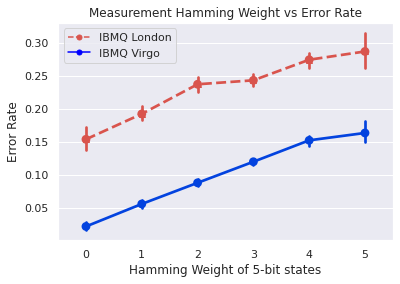

In [286]:
fig = plt.figure()
ax = sbs.pointplot(x_coords_l, y_coords_l, ci=100, label="IBMQ London", 
                   color=sbs.xkcd_rgb["pale red"], marker='.', markersize=7)

ax.lines[0].set_marker('^')
ax.lines[0].set_linestyle('--')

sbs.pointplot(x_coords_v, y_coords_v, ci=100, label="IBMQ Virgo", color=sbs.xkcd_rgb["blue"], ax=ax, markersize=7)
plt.xlabel("Hamming Weight of 5-bit states")
plt.ylabel("Error Rate")

virgo = mlines.Line2D([], [], color=sbs.xkcd_rgb["pale red"], marker='.', linestyle='--',
                          markersize=10, label='IBMQ London')
london = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=10, label='IBMQ Virgo')

plt.legend(handles=[virgo, london])

plt.title("Measurement Hamming Weight vs Error Rate")
plt.savefig('figs/error_rates_hamming.pdf')

Text(0, 0.5, 'Error Rate')

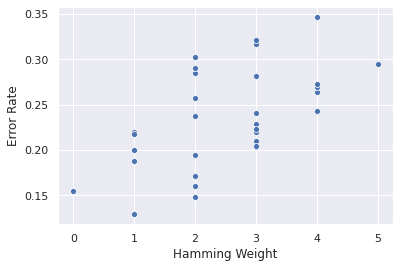

In [100]:
x_values = [sum(i) for i, result in results]
y_values = [1 - result[''.join(list(reversed(''.join(map(str, i)))))]/1000 for i, result in results]
sbs.scatterplot(x_values, y_values)
plt.xlabel("Hamming Weight")
plt.ylabel("Error Rate")

In [290]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

In [297]:
x = random_circuit(3)
x.draw()

┌───┐ ┌───┐      ░ ┌───┐┌───┐  ░  ┌───┐ ░ 
qr_0: ─┤ H ├─┤ X ├──────░─┤ X ├┤ H ├──░──┤ X ├─░─
      ┌┴───┴┐├───┤┌───┐ ░ ├───┤├───┤┌───┐└─░─┘ ░ 
qr_1: ┤ SDG ├┤ H ├┤ Z ├─░─┤ Z ├┤ H ├┤ S ├──░─────
      └┬───┬┘└─░─┘├───┤ ░ ├───┤└─░─┘└───┘  ░     
qr_2: ─┤ X ├───░──┤ X ├─░─┤ X ├──░───────────────
       └───┘   ░  └───┘ ░ └───┘  ░               
cr_0: ═══════════════════════════════════════════
                                                 
cr_1: ═══════════════════════════════════════════
                                                 
cr_2: ═══════════════════════════════════════════

In [298]:
x.measure([0,1,2], [0,1,2])

In [302]:
print(x.draw('latex_source'))

% \documentclass[preview]{standalone}
% If the image is too large to fit on this documentclass use
\documentclass[draft]{beamer}
% img_width = 6, img_depth = 12
\usepackage[size=custom,height=10,width=24,scale=0.7]{beamerposter}
% instead and customize the height and width (in cm) to fit.
% Large images may run out of memory quickly.
% To fix this use the LuaLaTeX compiler, which dynamically
% allocates memory.
\usepackage[braket, qm]{qcircuit}
\usepackage{amsmath}
\pdfmapfile{+sansmathaccent.map}
% \usepackage[landscape]{geometry}
% Comment out the above line if using the beamer documentclass.
\begin{document}
\begin{equation*}
    \Qcircuit @C=1.0em @R=0.0em @!R {
	 	\lstick{ {qr}_{0} :  } & \gate{H} & \gate{X} & \qw \barrier[0em]{1} & \qw & \gate{X} & \gate{H} \barrier[0em]{0} & \qw & \gate{X} \barrier[0em]{0} & \qw & \meter & \qw & \qw\\
	 	\lstick{ {qr}_{1} :  } & \gate{S^\dag} & \gate{H} & \gate{Z} & \qw & \gate{Z} & \gate{H} & \gate{S} \barrier[0em]{0} & \qw & \meter & \qw & \qw